### Import Packages

In [1]:
# filter warnings
import warnings
warnings.filterwarnings('ignore')

#import plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import string
import logging
import pandas as pd
import numpy as np
np.random.seed(0)
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams


from collections import Counter
from nltk.probability import FreqDist

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

#TextBlob
from textblob import TextBlob
from textblob import Word


In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint("test pretty print which will be helpful for json and list variable")

'test pretty print which will be helpful for json and list variable'


### Understanding the Data

In [3]:
data=pd.read_json('reviews_Office_Products_5.json',lines=True)
data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00000JBLH,"[3, 4]",5,"I bought my first HP12C in about 1984 or so, a...","09 3, 2004",A32T2H8150OJLU,ARH,"A solid performer, and long time friend",1094169600
1,B00000JBLH,"[7, 9]",5,WHY THIS BELATED REVIEW? I feel very obliged t...,"12 15, 2007",A3MAFS04ZABRGO,"Let it Be ""Alan""","Price of GOLD is up, so don't bury the golden ...",1197676800
2,B00000JBLH,"[3, 3]",2,I have an HP 48GX that has been kicking for mo...,"01 1, 2011",A1F1A0QQP2XVH5,Mark B,"Good functionality, but not durable like old HPs",1293840000
3,B00000JBLH,"[7, 8]",5,I've started doing more finance stuff recently...,"04 19, 2006",A49R5DBXXQDE5,R. D Johnson,One of the last of an almost extinct species,1145404800
4,B00000JBLH,"[0, 0]",5,For simple calculations and discounted cash fl...,"08 4, 2013",A2XRMQA6PJ5ZJ8,Roger J. Buffington,Still the best,1375574400


In [4]:
data['overall'] = data['overall'].astype(object) # fix datatype error
dataset = {"reviewText": data["reviewText"], "overall": data["overall"]  }
dataset = pd.DataFrame(data = dataset)
dataset = dataset.dropna()
dataset.head()

,reviewText,overall
0,"I bought my first HP12C in about 1984 or so, a...",5
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5
2,I have an HP 48GX that has been kicking for mo...,2
3,I've started doing more finance stuff recently...,5
4,For simple calculations and discounted cash fl...,5


In [5]:
dataset.head()

,reviewText,overall
0,"I bought my first HP12C in about 1984 or so, a...",5
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5
2,I have an HP 48GX that has been kicking for mo...,2
3,I've started doing more finance stuff recently...,5
4,For simple calculations and discounted cash fl...,5


In [6]:
dataset.to_csv('manu.csv',index=False)

In [7]:
dataset.dtypes

reviewText    object
overall       object
dtype: object

In [8]:
dataset['overall']=dataset['overall'].astype('int64')
dataset = dataset[dataset["overall"] != 3] # need datatype=object
dataset.shape

(48198, 2)

In [9]:
dataset["label"] = dataset["overall"].apply(lambda x : 1 if x > 3 else 0)
dataset[dataset["label"].isnull()]

,reviewText,overall,label


In [10]:
dataset.head()

,reviewText,overall,label
0,"I bought my first HP12C in about 1984 or so, a...",5,1
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5,1
2,I have an HP 48GX that has been kicking for mo...,2,0
3,I've started doing more finance stuff recently...,5,1
4,For simple calculations and discounted cash fl...,5,1


In [11]:
dataset.label.value_counts()

1    45342
0     2856
Name: label, dtype: int64

In [12]:
entire_dataset=dataset

In [13]:
# from sklearn.model_selection import train_test_split

# X = pd.DataFrame(entire_dataset, columns = ["reviewText","label"])
# y = pd.DataFrame(entire_dataset, columns = ["label"])

# dataset , X_test , y_train , y_test = train_test_split(X, y, random_state=50,stratify=y,train_size=0.7)

In [14]:
stop_words=set(stopwords.words("english"))

dataset['reviewText']=dataset['reviewText'].str.lower()

dataset['sentence']=dataset['reviewText'].apply(lambda x: sent_tokenize(x))

dataset['tokens']=dataset['reviewText'].apply(lambda x: word_tokenize(x))

In [15]:
def get_clean_token_list(words):
    clean_words=[]
    for word in words:
        flag=True
        for letter in word:
            if letter.isdigit() or letter in string.punctuation:
                flag=False
        if flag:
            clean_words.append(word)
    return clean_words

print(get_clean_token_list(["hewy","ho!w","are","yo6u","?dd","111","qwerty"]))

def remove_stopwords(words):
    """
    pass series get series
    """
    filtered_sent=[]
    for word in words:
        if word not in stop_words:
            filtered_sent.append(word)
    return filtered_sent


print(remove_stopwords(["hey","how","are","you","?"]))

['hewy', 'are', 'qwerty']
['hey', '?']


In [16]:
dataset['tokens']=dataset['tokens'].apply(remove_stopwords)

dataset['tokens'].head()

0    [bought, first, hp12c, 1984, ,, served, faithf...
1    [belated, review, ?, feel, obliged, share, vie...
2    [hp, 48gx, kicking, twenty, years, hp, 11, 25,...
3    ['ve, started, finance, stuff, recently, went,...
4    [simple, calculations, discounted, cash, flows...
Name: tokens, dtype: object

In [17]:
dataset['tokens']=dataset['tokens'].apply(get_clean_token_list)

dataset['tokens'].head()

0    [bought, first, served, faithfully, lost, trav...
1    [belated, review, feel, obliged, share, views,...
2    [hp, kicking, twenty, years, hp, years, old, s...
3    [started, finance, stuff, recently, went, look...
4    [simple, calculations, discounted, cash, flows...
Name: tokens, dtype: object

In [18]:
stem = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

def stem_sentence(sentence):
    stem_sentence=[]
    for word in sentence:
        stem_sentence.append(stem.stem(word))
    return stem_sentence

def lemmatize_sentence(sentence):
    lem_sentence=[]
    for word in sentence:
        lem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    return lem_sentence

In [19]:
dataset.head()

,reviewText,overall,label,sentence,tokens
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav..."
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,..."
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s..."
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look..."
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows..."


In [20]:
dataset['stem_sentence']=dataset['tokens'].apply(lambda x: stem_sentence(x))

dataset[['tokens','stem_sentence']].head(10)

dataset['lemm_sentence']=dataset['tokens'].apply(lambda x: lemmatize_sentence(x))

dataset[['tokens','lemm_sentence']].head(10)

,tokens,lemm_sentence
0,"[bought, first, served, faithfully, lost, trav...","[buy, first, serve, faithfully, lose, travel, ..."
1,"[belated, review, feel, obliged, share, views,...","[belated, review, feel, oblige, share, view, o..."
2,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenty, years, hp, years, old, stil..."
3,"[started, finance, stuff, recently, went, look...","[start, finance, stuff, recently, go, look, go..."
4,"[simple, calculations, discounted, cash, flows...","[simple, calculations, discount, cash, flow, o..."
5,"[mba, hard, believe, calculator, learned, use,...","[mba, hard, believe, calculator, learn, use, u..."
6,"[hp, ever, since, first, available, roughly, t...","[hp, ever, since, first, available, roughly, t..."
7,"[bought, boss, lost, loves, calculator, would,...","[buy, boss, lose, love, calculator, would, cat..."
8,"[simple, calculator, handles, typical, math, l...","[simple, calculator, handle, typical, math, la..."
9,"[love, calculator, big, numbers, calculate, ex...","[love, calculator, big, number, calculate, exc..."


In [21]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ..."
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o..."
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil..."
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go..."
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o..."


In [22]:
reviews=[word for review in dataset['lemm_sentence'] for word in review]

fdist_reviews = FreqDist(reviews)

fdist_reviews.most_common(10)

[('use', 61375),
 ('print', 30238),
 ('printer', 29298),
 ('one', 27926),
 ('paper', 26963),
 ('like', 26040),
 ('work', 24809),
 ('get', 24176),
 ('make', 22934),
 ('label', 21503)]

In [23]:
positive_reviews=dataset[dataset['label']==1]['lemm_sentence']

positive_tokens=[word for review in positive_reviews for word in review]

fdist_positive_tokens = FreqDist(positive_tokens)

fdist_positive_tokens.most_common(10)

[('use', 58058),
 ('print', 28033),
 ('printer', 26633),
 ('one', 25759),
 ('paper', 25196),
 ('like', 24400),
 ('work', 22932),
 ('get', 21847),
 ('make', 21464),
 ('label', 20859)]

In [24]:
negative_reviews=dataset[dataset['label']==0]['lemm_sentence']

negative_reviews=[word for review in negative_reviews for word in review]

fdist_neagtive_tokens = FreqDist(negative_reviews)

fdist_neagtive_tokens.most_common(10)

[('use', 3317),
 ('printer', 2665),
 ('get', 2329),
 ('print', 2205),
 ('one', 2167),
 ('would', 1954),
 ('work', 1877),
 ('paper', 1767),
 ('ink', 1652),
 ('like', 1640)]

In [25]:
len(fdist_neagtive_tokens.most_common())

10454

In [26]:
len(fdist_positive_tokens.most_common())

32915

In [27]:
frequency_tokens={ x[0]:x[1] for x in fdist_positive_tokens.most_common()}

In [28]:
dataset['pos_tag']=dataset['tokens'].apply(lambda x: nltk.pos_tag(x))

dataset['pos_tag'].head()

0    [(bought, VBD), (first, RB), (served, VBN), (f...
1    [(belated, VBN), (review, NN), (feel, NN), (ob...
2    [(hp, NN), (kicking, VBG), (twenty, CD), (year...
3    [(started, VBN), (finance, NN), (stuff, NN), (...
4    [(simple, JJ), (calculations, NNS), (discounte...
Name: pos_tag, dtype: object

In [29]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f..."
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob..."
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year..."
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (..."
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte..."


In [30]:
# keep only noun adjective and adverb
keep_tags=["JJ","JJR","JJS","RB","RBR","RBS","UH","NN","NNS","NNP","NNPS"]

def filter_tag(pos_list):
    pos_clean_list=[]
    for t in pos_list:
        if t[1] in keep_tags:
            pos_clean_list.append(t[0])
    return pos_clean_list

filter_tag([('asked', 'RB'), ('review', 'NN'), ('scale', 'RBS')])

['asked', 'review', 'scale']

In [31]:
dataset['filter_pos_tag']=dataset['pos_tag'].apply(filter_tag)

dataset[['tokens','filter_pos_tag']].head(10)

,tokens,filter_pos_tag
0,"[bought, first, served, faithfully, lost, trav...","[first, faithfully, travelling, difficult, com..."
1,"[belated, review, feel, obliged, share, views,...","[review, feel, share, views, old, workhorse, g..."
2,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, years, years, old, still, flawless, month..."
3,"[started, finance, stuff, recently, went, look...","[finance, stuff, recently, good, calculator, p..."
4,"[simple, calculations, discounted, cash, flows...","[simple, calculations, cash, flows, still, bes..."
5,"[mba, hard, believe, calculator, learned, use,...","[mba, hard, calculator, use, undergraduate, bu..."
6,"[hp, ever, since, first, available, roughly, t...","[hp, ever, first, available, roughly, years, a..."
7,"[bought, boss, lost, loves, calculator, would,...","[boss, loves, calculator, really, helps, day, ..."
8,"[simple, calculator, handles, typical, math, l...","[simple, calculator, handles, typical, math, l..."
9,"[love, calculator, big, numbers, calculate, ex...","[love, calculator, big, numbers, excellent, ea..."


In [32]:
dataset['clean_sentence']=dataset['filter_pos_tag'].apply(lambda x: ' '.join(x))

In [33]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, travelling, difficult, com...",first faithfully travelling difficult come are...
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[review, feel, share, views, old, workhorse, g...",review feel share views old workhorse gold ann...
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[hp, years, years, old, still, flawless, month...",hp years years old still flawless months numbe...
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (...","[finance, stuff, recently, good, calculator, p...",finance stuff recently good calculator pleasan...
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, calculations, cash, flows, still, bes...",simple calculations cash flows still best used...


In [34]:
def detect_polarity(col):
    return TextBlob(col).sentiment.polarity

def detect_subjectivity(col):
    return TextBlob(col).sentiment.subjectivity

def get_lemma(col):
    lemma_list = []
    text = TextBlob(col).words
    for item in text:
        lemma = Word(item).lemmatize()
        lemma_list.append(lemma)
    return lemma_list

def detect_sentence_polarity(col):
    scores = []
    for sentences in TextBlob(col).sentences:
        score = np.round(sentences.sentiment.polarity,2)
        scores.append(score)
    return scores

def sentence_count(col_name, sign = 'total'):
    # TODO : OPTIMIZE this
    count_list = []
    for reviews in col_name:
        total_count = len(reviews)
        if sign == 'total':
            count_list.append(total_count)
        else:
            count = 0
            for polarity in reviews:
                if sign == 'positive' and polarity >= 0.4 :
                    count += 1
                elif sign == 'neutral' and polarity >=0 and polarity<0.4:
                    count += 1
                elif sign == 'negative' and polarity <0 :
                    count += 1
            count_list.append(count)
    return count_list 



def negative_boolean(col):
    value = 0
    value_list = []
    for sentence in col:
        polarity = detect_polarity(sentence)
        if polarity < 0:
            value = 1
        else: 
            value = 0
        value_list.append(value)
    return value_list

filter_method = lambda x:'Highly Positive' if x >= 0.5 else 'Fairly Positive' if (x > 0 and x < 0.5) else 'Highly Negative' if x <= -0.5 else 'Fairly Negative' if (x > -0.5 and x < 0) else 'Neutral'

In [35]:
# dataset['polarity'] = round(dataset.reviewText.apply(detect_polarity),1)
# dataset['subjectivity'] = round(dataset.reviewText.apply(detect_subjectivity),1)
# dataset['sentiment'] = dataset['polarity'].apply(filter_method)
# dataset['lemma'] = dataset.reviewText.apply(get_lemma)

dataset['sentence_sentiment'] = dataset.reviewText.apply(detect_sentence_polarity)

dataset['#positive_sentences'] = sentence_count(dataset['sentence_sentiment'], 'positive')
dataset['#negative_sentences'] = sentence_count(dataset['sentence_sentiment'], 'negative')
dataset['#neutral_sentences']= sentence_count(dataset['sentence_sentiment'], 'neutral')

dataset['% positive_sentences'] =np.round(dataset['#positive_sentences']*100/(dataset['#positive_sentences']+dataset['#negative_sentences']+dataset['#neutral_sentences']),2)
dataset['% negative_sentences'] =np.round(dataset['#negative_sentences']*100/(dataset['#positive_sentences']+dataset['#negative_sentences']+dataset['#neutral_sentences']),2)
dataset['% neutral_sentences'] =np.round(dataset['#neutral_sentences']*100/(dataset['#positive_sentences']+dataset['#negative_sentences']+dataset['#neutral_sentences']),2)

dataset.head(6)

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence,sentence_sentiment,#positive_sentences,#negative_sentences,#neutral_sentences,% positive_sentences,% negative_sentences,% neutral_sentences
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, travelling, difficult, com...",first faithfully travelling difficult come are...,"[0.25, -0.5, 0.0, 0.0, 0.42, 0.19, 0.0, 0.25, ...",1,1,8,10.00,10.00,80.00
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[review, feel, share, views, old, workhorse, g...",review feel share views old workhorse gold ann...,"[0.0, 0.27, 0.0, 0.18, 0.7, -0.03, 0.08, 0.4, ...",4,1,13,22.22,5.56,72.22
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[hp, years, years, old, still, flawless, month...",hp years years old still flawless months numbe...,"[0.52, -0.16, 0.0, 0.07, 0.15, 0.6, 0.17, -0.35]",2,2,4,25.00,25.00,50.00
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (...","[finance, stuff, recently, good, calculator, p...",finance stuff recently good calculator pleasan...,"[0.4, 0.25, 0.8, 0.38, 0.2, 0.0, 0.25, 0.35, 0...",4,5,33,9.52,11.90,78.57
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, calculations, cash, flows, still, bes...",simple calculations cash flows still best used...,"[0.5, 0.0, 0.18, 0.5, 0.72, 0.0, 0.0, 0.0]",3,0,5,37.50,0.00,62.50
5,"while i don't have an mba, it's hard to believ...",5,1,"[while i don't have an mba, it's hard to belie...","[mba, hard, believe, calculator, learned, use,...","[mba, hard, believ, calcul, learn, use, underg...","[mba, hard, believe, calculator, learn, use, u...","[(mba, RB), (hard, JJ), (believe, VBP), (calcu...","[mba, hard, calculator, use, undergraduate, bu...",mba hard calculator use undergraduate business...,"[0.01, 0.1, 0.17, 0.03, -0.02, 0.07, 0.0]",0,1,6,0.00,14.29,85.71


Polarity is float which lies within range of [-1,1]. Values closer to 1 have a highly positive sentiment and values closer to -1 have highly negative sentiment. Values closer to 0 on the either sides shows slighty positive and negative indication.

Similarly, subjective sentences refer to personal opinion, emotion or judgement whereas objective refers to facts. Subjectivity is also a float which lies in the range of [0,1]

In [36]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence,sentence_sentiment,#positive_sentences,#negative_sentences,#neutral_sentences,% positive_sentences,% negative_sentences,% neutral_sentences
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, travelling, difficult, com...",first faithfully travelling difficult come are...,"[0.25, -0.5, 0.0, 0.0, 0.42, 0.19, 0.0, 0.25, ...",1,1,8,10.00,10.00,80.00
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[review, feel, share, views, old, workhorse, g...",review feel share views old workhorse gold ann...,"[0.0, 0.27, 0.0, 0.18, 0.7, -0.03, 0.08, 0.4, ...",4,1,13,22.22,5.56,72.22
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[hp, years, years, old, still, flawless, month...",hp years years old still flawless months numbe...,"[0.52, -0.16, 0.0, 0.07, 0.15, 0.6, 0.17, -0.35]",2,2,4,25.00,25.00,50.00
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (...","[finance, stuff, recently, good, calculator, p...",finance stuff recently good calculator pleasan...,"[0.4, 0.25, 0.8, 0.38, 0.2, 0.0, 0.25, 0.35, 0...",4,5,33,9.52,11.90,78.57
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, calculations, cash, flows, still, bes...",simple calculations cash flows still best used...,"[0.5, 0.0, 0.18, 0.5, 0.72, 0.0, 0.0, 0.0]",3,0,5,37.50,0.00,62.50


In [37]:
dataset['% negative > % positive']=dataset['% negative_sentences']>=dataset['% positive_sentences']
dataset['negative > positive']=dataset['#negative_sentences']>=dataset['#positive_sentences']
dataset['% negative > 10']=dataset['% negative_sentences']>10
dataset['% positive > 50']=dataset['% positive_sentences']>50
dataset['contains_negative_sentence']=dataset['#negative_sentences']>0
dataset['#positive_sentences_mask']=dataset['#positive_sentences'].apply(lambda x: 1 if x ==0 else x)
dataset['negative/positive']=dataset['#negative_sentences']/dataset['#positive_sentences_mask']
dataset['negative/positive>0.4']=dataset['negative/positive']>=0.4

In [38]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence,...,% negative_sentences,% neutral_sentences,% negative > % positive,negative > positive,% negative > 10,% positive > 50,contains_negative_sentence,#positive_sentences_mask,negative/positive,negative/positive>0.4
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, travelling, difficult, com...",first faithfully travelling difficult come are...,...,10.00,80.00,True,True,False,False,True,1,1.00,True
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[review, feel, share, views, old, workhorse, g...",review feel share views old workhorse gold ann...,...,5.56,72.22,False,False,False,False,True,4,0.25,False
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[hp, years, years, old, still, flawless, month...",hp years years old still flawless months numbe...,...,25.00,50.00,True,True,True,False,True,2,1.00,True
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (...","[finance, stuff, recently, good, calculator, p...",finance stuff recently good calculator pleasan...,...,11.90,78.57,True,True,True,False,True,4,1.25,True
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, calculations, cash, flows, still, bes...",simple calculations cash flows still best used...,...,0.00,62.50,False,False,False,False,False,3,0.00,False


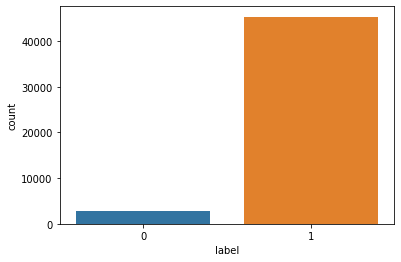

In [39]:
sns.countplot(x='label', data=dataset);

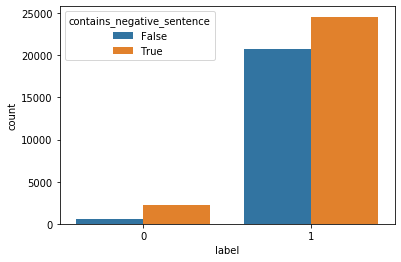

In [40]:
sns.countplot(x='label', data=dataset,hue='contains_negative_sentence');

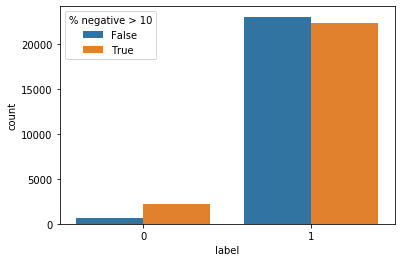

In [41]:
sns.countplot(x='label', data=dataset,hue='% negative > 10');

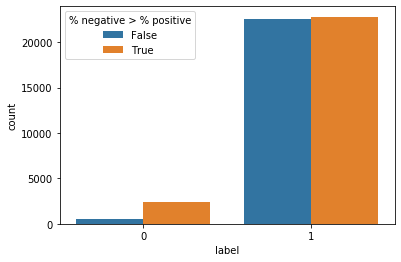

In [42]:
sns.countplot(x='label', data=dataset,hue='% negative > % positive');

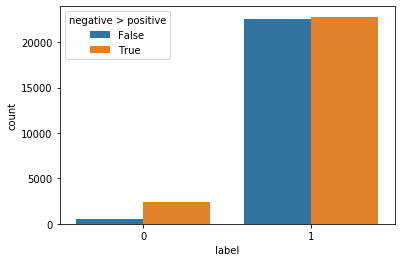

In [43]:
sns.countplot(x='label', data=dataset,hue='negative > positive');


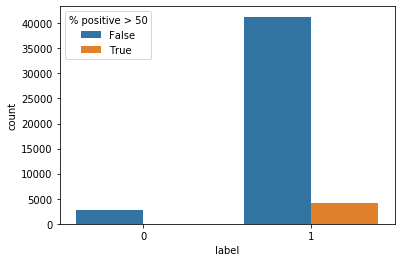

In [44]:
sns.countplot(x='label', data=dataset,hue='% positive > 50');

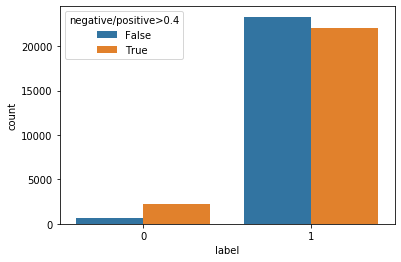

In [45]:
sns.countplot(x='label', data=dataset,hue='negative/positive>0.4');


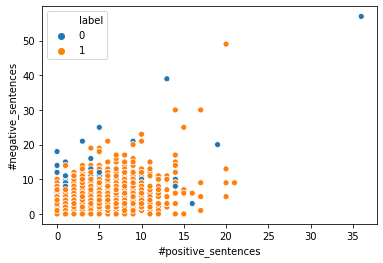

In [46]:
ax = sns.scatterplot(x="#positive_sentences", y="#negative_sentences", hue="label",data=dataset)

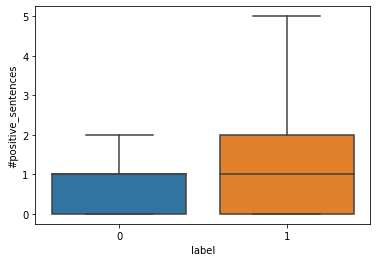

In [47]:
x = sns.boxplot(x="label", y="#positive_sentences", data=dataset,showfliers=False)

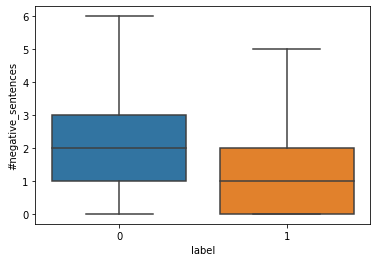

In [48]:
x = sns.boxplot(x="label", y="#negative_sentences", data=dataset,showfliers=False)

In [49]:
# ax = sns.boxplot(x=dataset["#positive_sentences"])

In [50]:
dataset[['#positive_sentences','#negative_sentences']].describe()

,#positive_sentences,#negative_sentences
count,48198.000000,48198.000000
mean,1.511059,1.127433
std,1.537071,1.640637
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,36.000000,57.000000


In [51]:
dataset[(dataset['#positive_sentences']>0 ) & (dataset['#positive_sentences']<=5 )& (dataset['label']==0 )&(dataset['#negative_sentences']>0)][['#positive_sentences','#negative_sentences','#neutral_sentences','label']].head(20)

,#positive_sentences,#negative_sentences,#neutral_sentences,label
2,2,2,4,0
43,1,2,10,0
309,1,3,4,0
644,1,3,10,0
724,1,6,11,0
743,1,1,3,0
1048,1,2,2,0
1055,1,1,3,0
1101,3,2,8,0
1305,1,3,3,0


In [52]:
dataset[dataset['label']==0][['#positive_sentences','#negative_sentences']].corr()

,#positive_sentences,#negative_sentences
#positive_sentences,1.000000,0.521589
#negative_sentences,0.521589,1.000000


In [53]:
print(dataset[['#positive_sentences','#negative_sentences','label']].groupby('label').describe().unstack(1))

                            label
#positive_sentences  count  0         2856.000000
                            1        45342.000000
                     mean   0            1.027661
                            1            1.541507
                     std    0            1.563912
                            1            1.530278
                     min    0            0.000000
                            1            0.000000
                     25%    0            0.000000
                            1            0.000000
                     50%    0            1.000000
                            1            1.000000
                     75%    0            1.000000
                            1            2.000000
                     max    0           36.000000
                            1           21.000000
#negative_sentences  count  0         2856.000000
                            1        45342.000000
                     mean   0            2.140406
                

In [54]:
dataset[dataset['label']==0].head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence,...,% negative_sentences,% neutral_sentences,% negative > % positive,negative > positive,% negative > 10,% positive > 50,contains_negative_sentence,#positive_sentences_mask,negative/positive,negative/positive>0.4
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[hp, years, years, old, still, flawless, month...",hp years years old still flawless months numbe...,...,25.00,50.00,True,True,True,False,True,2,1.0,True
32,these ubiquitous texas instrument calculator t...,1,0,[these ubiquitous texas instrument calculator ...,"[ubiquitous, texas, instrument, calculator, ev...","[ubiquit, texa, instrument, calcul, everyon, t...","[ubiquitous, texas, instrument, calculator, ev...","[(ubiquitous, JJ), (texas, NN), (instrument, N...","[ubiquitous, texas, instrument, calculator, ev...",ubiquitous texas instrument calculator everyon...,...,0.00,50.00,False,False,False,False,False,1,0.0,False
37,overall i do not recommend this product. i rem...,2,0,"[overall i do not recommend this product., i r...","[overall, recommend, product, remember, calcul...","[overal, recommend, product, rememb, calcul, s...","[overall, recommend, product, remember, calcul...","[(overall, JJ), (recommend, VB), (product, NN)...","[overall, product, calculator, several, years,...",overall product calculator several years ago v...,...,16.67,83.33,True,True,True,False,True,1,1.0,True
40,bought this product recently based on recommen...,1,0,[bought this product recently based on recomme...,"[bought, product, recently, based, recommendat...","[bought, product, recent, base, recommend, adv...","[buy, product, recently, base, recommendations...","[(bought, JJ), (product, NN), (recently, RB), ...","[bought, product, recently, recommendations, s...",bought product recently recommendations scient...,...,40.00,60.00,True,True,True,False,True,1,2.0,True
43,parents: if you're going to buy your child a g...,2,0,[parents: if you're going to buy your child a ...,"[parents, going, buy, child, graphing, calcula...","[parent, go, buy, child, graph, calcul, school...","[parent, go, buy, child, graph, calculator, sc...","[(parents, NNS), (going, VBG), (buy, NN), (chi...","[parents, buy, child, calculator, school, insu...",parents buy child calculator school insult int...,...,15.38,76.92,True,True,True,False,True,1,2.0,True


In [55]:
#Function to calculate Model Metrics

def get_model_metrics(actual,predicted):
    """
    Print Summary Metrics of the Model

    Parameters:
    actual (pandas.core.series.Series): Series of Boolean values for target column
    predicted (pandas.core.series.Series): Series of Boolean values for Model predicted the target column
    
    Returns:
    None

   """

    
    confusion = metrics.confusion_matrix(actual,predicted )
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    accuracy=metrics.accuracy_score(actual,predicted)
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN+FP)
    precision=TP/float(FP+TP)
    recall=TP/float(FN+TP)
    
    precision=metrics.precision_score(actual,predicted)
    recall=metrics.recall_score(actual,predicted)
    f1=metrics.f1_score(actual,predicted, average='weighted') 
    print("Accuracy    : "+str(round(accuracy,2)))
    print("Sensitivity : "+str(round(sensitivity,2)))
    print("Specificity : "+str(round(specificity,2)))
    print("Precision   : "+str(round(precision,2)))
    print("Recall      : "+str(round(recall,2)))
    print("F1_score    : "+str(round(f1,2)))
    
# fokal ml utils

def get_cross_validated_model_metrics(X,y,cv=5):
    """
    Get cross validated model metric for k folds

    Parameters:
    X (pandas.core.frame.DataFrame): DF of all the features excluding target column
    y (pandas.core.series.Series): Series of Boolean values of the target column
    
    Returns:
    df (pandas.core.frame.DataFrame): DF will all the metric for k fold

   """
    accuracy=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='accuracy')
    precision=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='precision')
    recall=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='recall')
    f1_weighted=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='f1_weighted')
    roc_auc=cross_val_score(logregcv, X, y, cv=cv,n_jobs=-1,scoring='roc_auc')
    df=pd.DataFrame(
    {'accuracy': accuracy,
     'precision': precision,
     'recall': recall,
     'f1_weighted': f1_weighted,
     'roc_auc': roc_auc,
    })
    return df

logregcv = LogisticRegressionCV(class_weight='balanced',cv=5)

In [56]:
import math
import numpy as np
import pandas as pd
from collections import Counter


class TfIdfExtractor(object):

    def gen_tf_score(self, doc):
        return Counter(doc)

    def gen_df_score(self, doc_list):

        idf_corpus = {}
        doc_cntr = 0
        for doc in doc_list:
            ## TODO: Handle Bad docs
            if len(doc) == 0: continue

            doc_cntr += 1
            tf_doc = self.gen_tf_score(doc)
            idf_corpus.update(
                {_k: idf_corpus.get(_k, 0) + 1 for _k, _v in tf_doc.items()})  # Add for the presence of term
            #tf_doc = {_k: _v / len(doc) for _k, _v in tf_doc.items()}

        return idf_corpus, doc_cntr

    def gen_tf_idf_scores(self, doc_list):

        global_tfidf= {}

        # Obtain the document frequency scores
        df_scores, num_doc = self.gen_df_score(doc_list)

        for doc in doc_list:
            tf_doc = Counter(doc)

            for _term, _freq in tf_doc.items():
                _term_idf = df_scores.get(_term, 0)
                if _term_idf > 0:
                    tfidf_score = _freq * math.log10(num_doc / _term_idf)
                else:
                    raise Exception("TFIDF calculation failed!")

                if _term in global_tfidf:
                    global_tfidf[_term].append(tfidf_score)
                else:
                    global_tfidf[_term] = [tfidf_score]

                #global_tfidf[_term] = [tfidf_score]

        return global_tfidf

    def gen_tf_idf_stats_df(self, doc_list):

        global_tfidf = self.gen_tf_idf_scores(doc_list)

        tfidf_list = []
        for _term in global_tfidf:
            tfidf_dict = {}
            tfidf_scores = global_tfidf[_term]
            tfidf_dict['term'] = _term
            # tfidf_dict['mode'] = mode(tfidf_scores)
            tfidf_dict['mean'] = np.mean(tfidf_scores)
            tfidf_dict['median'] = np.median(tfidf_scores)
            tfidf_dict['min'] = min(tfidf_scores)
            tfidf_dict['max'] = max(tfidf_scores)
            tfidf_dict['freq'] = len(tfidf_scores)
            tfidf_list.append(tfidf_dict)

        tfidf_df = pd.DataFrame(tfidf_list)
        return tfidf_df

In [57]:
# corp_proc_tokens = list(dataset[''])
# tfidf_df = TfIdfExtractor().gen_tf_idf_stats_df(corp_proc_tokens)

In [58]:
from sklearn.model_selection import train_test_split

X = dataset
y = pd.DataFrame(dataset, columns = ["label"])

X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=50,stratify=y,train_size=0.7)

In [59]:
X_train.label.value_counts()

1    31739
0     1999
Name: label, dtype: int64

In [60]:
3989/29749

0.1340885407912871

In [61]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
dataset_vector = vectorizer.fit_transform(X_train["clean_sentence"])


In [62]:
print(dataset_vector[0].shape)

(1, 30443)


In [63]:
print(dataset_vector.shape)

(33738, 30443)


In [64]:
dataset.shape

(48198, 25)

In [65]:
len(vectorizer.vocabulary_)

30443

In [66]:
# vectorizer.vocabulary_

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
dataset_vector = vectorizer.fit_transform(X_train["clean_sentence"])


chi2_selector = chi2(dataset_vector, X_train['label'])

list_tokens=[]
for key, val in vectorizer.vocabulary_.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if key in frequency_tokens:
            list_tokens.append([key,val,frequency_tokens[key],chi2_selector[0][val],chi2_selector[1][val]])

In [68]:
unigram_df=pd.DataFrame(list_tokens,columns=['token','index','frquency','chi2','p_value'])

In [69]:
unigram_df.head()

,token,index,frquency,chi2,p_value
0,sharpie,23604,951,0.041787,8.380266e-01
1,bold,2734,568,0.707124,4.004003e-01
2,clean,4454,2677,0.998970,3.175598e-01
3,solid,24553,1866,6.256164,1.237619e-02
4,product,20499,10598,174.238228,8.781325e-40


In [70]:
unigram_df.sort_values(by='chi2',ascending=False).head(10)

,token,index,frquency,chi2,p_value
1573,poor,19771,290,448.821425,1.301987e-99
110,printer,20290,26633,426.733519,8.353022e-95
1560,useless,28771,229,371.991124,6.897120e-83
710,support,25883,1915,365.103304,2.179594e-81
845,customer,6135,488,357.687075,8.978858e-80
86,hp,12254,4094,350.685178,3.005612e-78
4977,refund,21622,35,325.801453,7.893216e-73
124,service,23443,1145,305.610285,1.974769e-68
1552,worst,30089,97,301.471966,1.574281e-67
1241,bad,1950,1363,300.815176,2.188632e-67


In [71]:
# filter on chi pvalue and frequency
unigram_df=unigram_df[(unigram_df['chi2']>10)&(unigram_df['frquency']>10)&(unigram_df['p_value']<0.05)]

In [72]:
unigram_df[unigram_df.token.str.contains('garbage')]
# significant
#frequency cutoff -5

,token,index,frquency,chi2,p_value
4143,garbage,10593,109,82.266333,1.189308e-19


In [73]:
unigram_df.sort_values(by='p_value',ascending=False).head(10)

,token,index,frquency,chi2,p_value
6246,profit,20537,55,10.030704,0.001540
4680,recognize,21445,422,10.030704,0.001540
3141,bug,3202,103,10.030704,0.001540
959,restart,22122,77,10.030704,0.001540
1750,workforce,30027,1151,10.041827,0.001530
1855,oem,17651,328,10.109230,0.001475
511,ago,614,1124,10.112687,0.001473
2974,c,3396,74,10.115090,0.001471
1655,english,8451,145,10.214721,0.001393
3404,twenty,27859,156,10.235114,0.001378


In [74]:
s=' '.join(list(X_train['clean_sentence']))

s = s.lower()
s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
tokens = [token for token in s.split(" ") if token != ""]

# 2grams
bgs = nltk.bigrams(tokens)

#compute frequency distribution for all the bigrams in the text
bigram_fdist = nltk.FreqDist(bgs)
tmp_bigram_frequency_tokens={ x[0]:x[1] for x in bigram_fdist.most_common()}
# pp.pprint(bigram_frequency_tokens)

#3grams
bgs = nltk.trigrams(tokens)

#compute frequency distribution for all the trigrams in the text
trigram_fdist = nltk.FreqDist(bgs)
tmp_trigram_frequency_tokens={ x[0]:x[1] for x in trigram_fdist.most_common()}
# pp.pprint(trigram_frequency_tokens)

In [75]:
bigram_frequency_tokens={}
for key , value in tmp_bigram_frequency_tokens.items():
    bigram_frequency_tokens[key[0]+" "+key[1]]=value

trigram_frequency_tokens={}
for key , value in tmp_trigram_frequency_tokens.items():
    trigram_frequency_tokens[key[0]+" "+key[1]+" "+key[2]]=value

In [76]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', ngram_range=(2, 2))
dataset_vector = vectorizer.fit_transform(X_train["clean_sentence"])


chi2_selector = chi2(dataset_vector, X_train['label'])

list_tokens=[]
for key, val in vectorizer.vocabulary_.items():
        if key in bigram_frequency_tokens:
            list_tokens.append([key,val,bigram_frequency_tokens[key],chi2_selector[0][val],chi2_selector[1][val]])

In [77]:
bigram_df=pd.DataFrame(list_tokens,columns=['token','index','frquency','chi2','p_value'])

In [78]:
bigram_df.sort_values(by='chi2',ascending=False).head(10)

,token,index,frquency,chi2,p_value
2848,file box,239685,92,404.577083,5.553609e-90
7027,waste money,758191,56,385.346925,8.528500e-86
2505,tech support,695770,133,366.424157,1.124025e-81
433706,buy store,83397,17,206.627979,7.474343e-47
13001,customer service,151174,209,202.887641,4.894472e-46
113644,refillable cartridges,568609,16,191.014370,1.909497e-43
23058,poor quality,512171,48,167.285054,2.898445e-38
57030,piece junk,500999,22,152.977721,3.873843e-35
33739,best buy,54129,60,150.632605,1.260925e-34
110974,free postage,260177,13,144.417078,2.880076e-33


In [79]:
bigram_df.sort_values(by='p_value',ascending=False).head(10)

,token,index,frquency,chi2,p_value
54109,fit right,247762,17,0.000056,0.994048
69626,messenger bag,406615,17,0.000056,0.994048
37048,pencil work,486317,17,0.000056,0.994048
51362,front computer,262251,17,0.000056,0.994048
29377,ever problem,215554,17,0.000056,0.994048
114163,printers scanners,531074,17,0.000056,0.994048
118715,kids also,344239,17,0.000056,0.994048
26243,minutes install,411251,17,0.000056,0.994048
72003,well smooth,766333,17,0.000056,0.994048
19947,printer larger,528791,17,0.000056,0.994048


In [80]:
# filter on chi pvalue and frequency
bigram_df=bigram_df[(bigram_df['chi2']>10)&(bigram_df['frquency']>10)&(bigram_df['p_value']<0.05)]

In [81]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', ngram_range=(3, 3))
dataset_vector = vectorizer.fit_transform(X_train["clean_sentence"])


chi2_selector = chi2(dataset_vector, X_train['label'])

list_tokens=[]
for key, val in vectorizer.vocabulary_.items():
        if key in trigram_frequency_tokens:
            list_tokens.append([key,val,trigram_frequency_tokens[key],chi2_selector[0][val],chi2_selector[1][val]])

In [82]:
trigram_df=pd.DataFrame(list_tokens,columns=['token','index','frquency','chi2','p_value'])

In [83]:
trigram_df.sort_values(by='chi2',ascending=False).head(10)

,token,index,frquency,chi2,p_value
983539,best buy store,92563,14,222.284142,2.871874e-50
49623,worst printer ever,1449326,6,95.264632,1.665625e-22
96702,full list price,465946,7,79.950111,3.839836e-19
214366,press start button,955109,8,68.479965,1.281732e-16
96707,genuine brother supplies,475327,8,68.479965,1.281732e-16
59739,ink system failure,581853,6,64.499825,9.654092e-16
801984,read fine print,1045494,6,64.499825,9.654092e-16
692319,hp printer best,555961,6,64.499825,9.654092e-16
96718,toner powder refills,1330808,4,63.509755,1.595746e-15
628839,best buy oakland,92551,4,63.509755,1.595746e-15


In [84]:
# filter on chi pvalue and frequency
trigram_df=trigram_df[(trigram_df['chi2']>10)&(trigram_df['frquency']>10)&(trigram_df['p_value']<0.05)]

In [85]:
#build master cir square df

master_chi_sq_df=pd.concat([trigram_df,bigram_df,unigram_df])

In [86]:
master_chi_sq_df.shape

(1423, 5)

In [87]:
master_chi_sq_df.reset_index(drop=True,inplace=True)

In [88]:
master_chi_sq_df=master_chi_sq_df[master_chi_sq_df.chi2>10]

In [89]:
master_chi_sq_df.head()

,token,index,frquency,chi2,p_value
0,ink cartridges printer,577425,39,14.889288,1.140086e-04
1,mo file box,742743,13,53.558605,2.509926e-13
2,laser printer wireless,641177,11,18.284105,1.902883e-05
3,black white text,115672,22,11.142632,8.436612e-04
4,matter many times,724486,12,41.821264,1.000099e-10


In [90]:
feature_list=master_chi_sq_df['token'].to_list()

In [91]:
len(feature_list)

1423

In [92]:
for feature in feature_list:
    X_train[feature]=X_train.clean_sentence.apply(lambda x: 1 if feature in x else 0)
    X_test[feature]=X_test.clean_sentence.apply(lambda x: 1 if feature in x else 0)

In [93]:
X_test.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence,...,participation,suprised,rig,omit,deceive,lapinator,purport,instal,rethink,prepay
5527,"interestingly, you can open this binder with e...",4,0,"[interestingly, you can open this binder with ...","[interestingly, open, binder, either, bottom, ...","[interestingli, open, binder, either, bottom, ...","[interestingly, open, binder, either, bottom, ...","[(interestingly, RB), (open, JJ), (binder, NN)...","[interestingly, open, binder, bottom, top, tab...",interestingly open binder bottom top tabs clos...,...,0,0,0,0,0,0,0,0,0,0
27611,these scotch reusable strips for lightweight m...,5,0,[these scotch reusable strips for lightweight ...,"[scotch, reusable, strips, lightweight, mounti...","[scotch, reusabl, strip, lightweight, mount, t...","[scotch, reusable, strip, lightweight, mount, ...","[(scotch, NN), (reusable, JJ), (strips, NNS), ...","[scotch, reusable, strips, terrific, far, ever...",scotch reusable strips terrific far everything...,...,0,0,1,0,0,0,0,0,0,0
1564,"these are good, standard solid labels from ave...",4,1,"[these are good, standard solid labels from av...","[good, standard, solid, labels, avery, templat...","[good, standard, solid, label, averi, templat,...","[good, standard, solid, label, avery, template...","[(good, JJ), (standard, NN), (solid, JJ), (lab...","[good, standard, solid, labels, avery, templat...",good standard solid labels avery template sugg...,...,0,0,1,0,0,0,0,0,0,0
10206,"this is one of the most powerful staplers, i h...",4,0,"[this is one of the most powerful staplers, i ...","[one, powerful, staplers, used, claim, finger,...","[one, power, stapler, use, claim, finger, oper...","[one, powerful, staplers, use, claim, finger, ...","[(one, CD), (powerful, JJ), (staplers, NNS), (...","[powerful, staplers, claim, finger, operation,...",powerful staplers claim finger operation true ...,...,0,0,0,0,0,0,0,0,0,0
2824,we use zebra pens in our office and they last ...,5,0,[we use zebra pens in our office and they last...,"[use, zebra, pens, office, last, well, write, ...","[use, zebra, pen, offic, last, well, write, ni...","[use, zebra, pen, office, last, well, write, n...","[(use, NN), (zebra, NN), (pens, VBZ), (office,...","[use, zebra, office, last, well, write, nice, ...",use zebra office last well write nice fine tip...,...,0,0,0,0,0,0,0,0,0,0


In [94]:
# try with only feature list

In [95]:
# from sklearn.model_selection import train_test_split

# X = dataset[feature_list]
# y = pd.DataFrame(dataset, columns = ["label"])

# X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=50,stratify=y,train_size=0.7)

In [96]:
log_reg_model = LogisticRegressionCV(class_weight='balanced')
log_reg_model.fit(X_train[feature_list], y_train)
scores = log_reg_model.score(X_test[feature_list], y_test) # accuracy
print(scores)

0.8572614107883817


In [97]:
#Making prediction on the train data
y_train_pred = log_reg_model.predict_proba(X_train[feature_list])[:,1]

#Making prediction on the test data
y_pred = log_reg_model.predict_proba(X_test[feature_list])[:,1]

y_train_pred=pd.Series(y_train_pred)
y_pred=pd.Series(y_pred)



In [98]:
y_pred_bool= y_pred.apply(lambda x: 1 if x>=0.134 else 0)
y_train_pred_bool= y_train_pred.apply(lambda x: 1 if x>=0.134 else 0)

In [99]:
metrics.confusion_matrix(y_train,y_train_pred_bool)

array([[ 1222,   777],
       [  920, 30819]])

In [100]:
get_model_metrics(y_train,y_train_pred_bool)

Accuracy    : 0.95
Sensitivity : 0.97
Specificity : 0.61
Precision   : 0.98
Recall      : 0.97
F1_score    : 0.95


In [101]:
metrics.confusion_matrix(y_test,y_pred_bool)

array([[  360,   497],
       [  535, 13068]])

In [102]:
get_model_metrics(y_test,y_pred_bool)

Accuracy    : 0.93
Sensitivity : 0.96
Specificity : 0.42
Precision   : 0.96
Recall      : 0.96
F1_score    : 0.93


In [103]:
dataset.columns.values

array(['reviewText', 'overall', 'label', 'sentence', 'tokens',
       'stem_sentence', 'lemm_sentence', 'pos_tag', 'filter_pos_tag',
       'clean_sentence', 'sentence_sentiment', '#positive_sentences',
       '#negative_sentences', '#neutral_sentences',
       '% positive_sentences', '% negative_sentences',
       '% neutral_sentences', '% negative > % positive',
       'negative > positive', '% negative > 10', '% positive > 50',
       'contains_negative_sentence', '#positive_sentences_mask',
       'negative/positive', 'negative/positive>0.4'], dtype=object)

In [104]:
dataset[dataset['negative/positive']>10]

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence,...,% negative_sentences,% neutral_sentences,% negative > % positive,negative > positive,% negative > 10,% positive > 50,contains_negative_sentence,#positive_sentences_mask,negative/positive,negative/positive>0.4
16534,this appears to be sized for standard 8.5 x 11...,4,1,[this appears to be sized for standard 8.5 x 1...,"[appears, sized, standard, x, inch, paper, pap...","[appear, size, standard, x, inch, paper, paper...","[appear, size, standard, x, inch, paper, paper...","[(appears, VBZ), (sized, JJ), (standard, NN), ...","[sized, standard, x, inch, paper, paper, legal...",sized standard x inch paper paper legal inches...,...,55.00,40.00,True,True,True,False,True,1,11.0,True
18437,this phone has changed my life. after sufferin...,5,1,"[this phone has changed my life., after suffer...","[phone, changed, life, suffering, motley, coll...","[phone, chang, life, suffer, motley, collect, ...","[phone, change, life, suffer, motley, collecti...","[(phone, NN), (changed, VBD), (life, NN), (suf...","[phone, life, motley, collection, various, pho...",phone life motley collection various phones ma...,...,27.50,70.00,True,True,True,False,True,1,11.0,True
18591,avery has long been known for making quality l...,5,1,[avery has long been known for making quality ...,"[avery, long, known, making, quality, labels, ...","[averi, long, known, make, qualiti, label, exc...","[avery, long, know, make, quality, label, exce...","[(avery, RB), (long, RB), (known, VBN), (makin...","[avery, long, quality, labels, never, even, re...",avery long quality labels never even repositio...,...,36.67,60.00,True,True,True,False,True,1,11.0,True
21152,hp has been a big name in inkjet and laser pri...,2,0,[hp has been a big name in inkjet and laser pr...,"[hp, big, name, inkjet, laser, printers, quite...","[hp, big, name, inkjet, laser, printer, quit, ...","[hp, big, name, inkjet, laser, printers, quite...","[(hp, NN), (big, JJ), (name, NN), (inkjet, NN)...","[hp, big, name, inkjet, laser, printers, quite...",hp big name inkjet laser printers quite time m...,...,30.00,68.00,True,True,True,False,True,1,15.0,True
30601,>>low force design makes it 40% easier to use ...,2,0,[>>low force design makes it 40% easier to use...,"[low, force, design, makes, easier, use, stand...","[low, forc, design, make, easier, use, standar...","[low, force, design, make, easier, use, standa...","[(low, JJ), (force, NN), (design, NN), (makes,...","[low, force, design, easier, use, standard, ne...",low force design easier use standard never tro...,...,64.71,29.41,True,True,True,False,True,1,11.0,True
33886,i have been scanning both old photographs and ...,5,1,[i have been scanning both old photographs and...,"[scanning, old, photographs, negative, strips,...","[scan, old, photograph, neg, strip, strip, pho...","[scan, old, photograph, negative, strip, strip...","[(scanning, VBG), (old, JJ), (photographs, JJ)...","[old, photographs, negative, strips, strips, p...",old photographs negative strips strips photos ...,...,26.83,70.73,True,True,True,False,True,1,11.0,True
37819,i have owned and/or reviewed over 5 different ...,2,0,[i have owned and/or reviewed over 5 different...,"[owned, reviewed, different, kinds, one, far, ...","[own, review, differ, kind, one, far, worthles...","[own, review, different, kinds, one, far, wort...","[(owned, VBN), (reviewed, VBD), (different, JJ...","[different, kinds, far, worthless, piece, equi...",different kinds far worthless piece equipment ...,...,26.19,71.43,True,True,True,False,True,1,11.0,True
40606,i sometimes telecommute from my engineering jo...,4,1,[i sometimes telecommute from my engineering j...,"[sometimes, telecommute, engineering, job, hom...","[sometim, telecommut, engin, job, home, often,...","[sometimes, telecommute, engineer, job, home, ...","[(sometimes, RB), (telecommute, JJ), (engineer...","[sometimes, telecommute, engineering, jo

In [105]:

additional_features=feature_list+['#positive_sentences',
       '#negative_sentences', '#neutral_sentences', '% negative > % positive',
       '% negative > 10', '% positive > 50', 'contains_negative_sentence',
       'negative > positive', 'negative/positive', 'negative/positive>0.4']

In [106]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_1= pd.DataFrame(scaler.fit_transform(X_train[additional_features]), index=X_train.index, columns=additional_features)

X_test_1= pd.DataFrame(scaler.transform(X_test[additional_features]), index=X_test.index, columns=additional_features)
X_train_1.head()

,ink cartridges printer,mo file box,laser printer wireless,black white text,matter many times,amazon vine program,press power button,paper regular paper,pages cents page,cents page cents,...,#positive_sentences,#negative_sentences,#neutral_sentences,% negative > % positive,% negative > 10,% positive > 50,contains_negative_sentence,negative > positive,negative/positive,negative/positive>0.4
30346,-0.038525,-0.018863,-0.01806,-0.024957,-0.018863,-0.056932,-0.016335,-0.020375,-0.012175,-0.016335,...,-0.982736,-0.077773,0.300423,0.958248,0.980741,-0.307699,0.889837,0.957338,0.237852,0.993500
466,-0.038525,-0.018863,-0.01806,-0.024957,-0.018863,-0.056932,-0.016335,-0.020375,-0.012175,-0.016335,...,0.318247,-0.682361,0.097242,-1.043571,-1.019637,-0.307699,-1.123801,-1.044563,-0.710407,-1.006542
4335,-0.038525,-0.018863,-0.01806,-0.024957,-0.018863,-0.056932,-0.016335,-0.020375,-0.012175,-0.016335,...,-0.982736,-0.682361,-0.105939,0.958248,-1.019637,-0.307699,-1.123801,0.957338,-0.710407,-1.006542
37664,-0.038525,-0.018863,-0.01806,-0.024957,-0.018863,-0.056932,-0.016335,-0.020375,-0.012175,-0.016335,...,-0.332245,1.131403,1.722690,0.958248,0.980741,-0.307699,0.889837,0.957338,2.134370,0.993500
35986,-0.038525,-0.018863,-0.01806,-0.024957,-0.018863,-0.056932,-0.016335,-0.020375,-0.012175,-0.016335,...,-0.982736,-0.682361,-0.512300,0.958248,-1.019637,-0.307699,-1.123801,0.957338,-0.710407,-1.006542


In [107]:
log_reg_model = LogisticRegressionCV(class_weight='balanced')
log_reg_model.fit(X_train_1[additional_features], y_train)
scores = log_reg_model.score(X_test_1[additional_features], y_test) # accuracy
print(scores)

0.8697786998616874


In [108]:
#Making prediction on the train data
y_train_pred = log_reg_model.predict_proba(X_train_1[additional_features])[:,1]

#Making prediction on the test data
y_pred = log_reg_model.predict_proba(X_test_1[additional_features])[:,1]

y_train_pred=pd.Series(y_train_pred)
y_pred=pd.Series(y_pred)

y_pred_bool= y_pred.apply(lambda x: 1 if x>=0.134 else 0)
y_train_pred_bool= y_train_pred.apply(lambda x: 1 if x>=0.134 else 0)

In [109]:
metrics.confusion_matrix(y_train,y_train_pred_bool)

array([[  534,  1465],
       [  149, 31590]])

In [110]:
metrics.confusion_matrix(y_test,y_pred_bool)

array([[  159,   698],
       [   76, 13527]])

In [111]:
get_model_metrics(y_train,y_train_pred_bool)

Accuracy    : 0.95
Sensitivity : 1.0
Specificity : 0.27
Precision   : 0.96
Recall      : 1.0
F1_score    : 0.94


In [112]:
get_model_metrics(y_test,y_pred_bool)

Accuracy    : 0.95
Sensitivity : 0.99
Specificity : 0.19
Precision   : 0.95
Recall      : 0.99
F1_score    : 0.93


In [113]:
# dataset.iloc[:100,:].to_csv('amazon_text_review_features.csv',index=False)

In [114]:
# dataset[dataset['label']==0].to_csv('amazon_text_review_negative_features.csv',index=False)

# Classification with word vectors v1

In [115]:
# X=dataset['filter_pos_tag'].to_list()
# y=dataset['label'].to_list()

In [116]:
from sklearn.feature_extraction.text import CountVectorizer

In [117]:
dataset.shape

(48198, 25)

In [118]:
X_train_text=dataset['clean_sentence'].to_list()
X_train_label=dataset['label'].to_list()

In [119]:
len(X_train_label)

48198

In [120]:
X_train,X_test,y_train,y_test=train_test_split(X_train_text,X_train_label, test_size=0.3,random_state=42)

In [121]:
vect = CountVectorizer(stop_words='english',max_features=5000)
vect = CountVectorizer(stop_words='english')
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [122]:
X_train_transformed = vect.transform(X_train)
X_test_transformed =vect.transform(X_test)

In [123]:
# printing the vocabulary
list(vect.vocabulary_.items())[:10]

[('quite', 20968),
 ('pretty', 20062),
 ('translucent', 27447),
 ('cover', 5717),
 ('bit', 2421),
 ('write', 30052),
 ('let', 14583),
 ('dry', 7777),
 ('version', 28913),
 ('little', 14857)]

### Using Bernoulli NB 

In [124]:
from sklearn.metrics import accuracy_score

In [125]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train_transformed,y_train)

# predict class
pred_train_ys = bnb.predict(X_train_transformed)
pred_test_ys = bnb.predict(X_test_transformed)

# accuracy
print("Train accuracy: ", accuracy_score(y_train, pred_train_ys))
print("Test accuracy: ", accuracy_score(y_test, pred_test_ys))

Train accuracy:  0.9119390598138597
Test accuracy:  0.9088520055325034


In [126]:
confusion_matrix(y_train, pred_train_ys)

array([[  591,  1426],
       [ 1545, 30176]])

### Using Multinomial NB
 - We expect this to work very well, giving high performance in accuracy

In [127]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

In [128]:
#fit on training data
mnb.fit(X_train_transformed, y_train)

# predict class
pred_train_ys = mnb.predict(X_train_transformed)
pred_test_ys = mnb.predict(X_test_transformed)

# accuracy
print("Train accuracy: ", accuracy_score(y_train, pred_train_ys))
print("Test accuracy: ", accuracy_score(y_test, pred_test_ys))

Train accuracy:  0.9484261070602881
Test accuracy:  0.9423236514522821


In [129]:
confusion_matrix(y_train, pred_train_ys)

array([[  809,  1208],
       [  532, 31189]])

 - As expected, this performed really well
 - Remember that we used 5000 features!

## Using our word embeddings approach

 We have two options here:
 
1. Use pre-trained word vectors (Glove)

2. Train our own vectors

We'll explore both 

In [130]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.200d.txt'
word2vec_output_file = 'glove.6B.200d.w2vformat.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 200)

In [131]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("glove.6B.200d.w2vformat.txt", binary=False)

### Sentence vector by averaging word vectors

In [132]:
stop_words = stopwords.words("english")

In [133]:
def sent_vec(sent):
    wv_res = np.zeros(glove_model.vector_size)
    ctr = 1
    for w in sent:
        if w in glove_model:
            ctr += 1
            wv_res += glove_model[w]
    wv_res = wv_res/ctr
    #return (wv_res, ctr)
    return wv_res

In [134]:
X_train,X_test,y_train,y_test=train_test_split(dataset['filter_pos_tag'],dataset['label'], test_size=0.3,random_state=42)

In [135]:
train_doc_vecs = []
for doc in X_train:    
    doc_words = [term for term in doc if term not in stop_words]
    train_doc_vecs.append(sent_vec(doc_words))

In [136]:
test_doc_vecs = []
for doc in X_test:    
    doc_words = [term for term in doc if term not in stop_words]
    test_doc_vecs.append(sent_vec(doc_words))

### Building a predictive model on the averaged word vectors

#### Using a 'simple' logistic regression

In [137]:
from sklearn.linear_model import LogisticRegression

In [138]:
logreg = LogisticRegression(penalty="l1", random_state=42, C = 2)
logreg.fit(train_doc_vecs,y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [139]:
pred_train_ys = logreg.predict(train_doc_vecs)
pred_test_ys = logreg.predict(test_doc_vecs)
print("Train accuracy: ", accuracy_score(pred_train_ys, y_train))
print("Test accuracy: ", accuracy_score(pred_test_ys, y_test))

Train accuracy:  0.9418163495168652
Test accuracy:  0.9432918395573997


In [140]:

y_train_pred = logreg.predict_proba(train_doc_vecs)[:,1]
# y_train_pred = y_train_pred.reshape(-1)
y_train_pred_final = pd.DataFrame({'is_positive_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.is_positive_Prob.map(lambda x: 1 if x > 0.7 else 0)
y_train_pred_final.head()

y_test_pred = logreg.predict_proba(test_doc_vecs)[:,1]
y_test_pred_final = pd.DataFrame({'is_positive_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.is_positive_Prob.map(lambda x: 1 if x > 0.7 else 0)
y_test_pred_final.head()

,is_positive_Prob,predicted
0,0.991460,1
1,0.945712,1
2,0.999866,1
3,0.997039,1
4,0.979068,1


In [141]:
print("Train accuracy: ", accuracy_score(pred_train_ys, y_train))
print("Test accuracy: ", accuracy_score(pred_test_ys, y_test))

Train accuracy:  0.9418163495168652
Test accuracy:  0.9432918395573997


In [142]:
confusion_matrix(y_train_pred_final.predicted, y_train)

array([[  496,   519],
       [ 1521, 31202]])

In [143]:
confusion_matrix(y_test_pred_final.predicted, y_test)

array([[  193,   242],
       [  646, 13379]])

# Training our own wordvectors on the data
We'll create a combined text file to train our word vectors - more data is better. Although in this case we would still have just 7.7K instances to learn from.

In [144]:
X_comb = np.concatenate([X_train,X_test])
len(X_comb)

48198

In [145]:
X_comb[6000]

['great',
 'marker',
 'boards',
 'size',
 'perfect',
 'shipment',
 'super',
 'fast',
 'always']

In [146]:
from gensim.models import word2vec
w2v = word2vec.Word2Vec(X_comb, window=2, min_count=2, sg = 1, size=200)

In [147]:
w2v.most_similar("difficult", topn=5)

[('tricky', 0.7496377229690552),
 ('awkward', 0.6867705583572388),
 ('harder', 0.6764732599258423),
 ('confusing', 0.67368483543396),
 ('afraid', 0.660274863243103)]

In [148]:
w2v.most_similar("printer", topn=5)

[('mfp', 0.757837176322937),
 ('printers', 0.7506860494613647),
 ('aio', 0.7395548820495605),
 ('deskjet', 0.7251192927360535),
 ('imageclass', 0.7250694036483765)]

In [149]:
w2v.most_similar("bad", topn=5)

[('terrible', 0.6442301273345947),
 ('weird', 0.6162554025650024),
 ('bothers', 0.6133352518081665),
 ('complain', 0.605831503868103),
 ('dislike', 0.6049333810806274)]

In [150]:
w2v.most_similar("customer", topn=5)

[('rep', 0.7406008243560791),
 ('request', 0.7317541837692261),
 ('representative', 0.7217728495597839),
 ('participation', 0.7159876823425293),
 ('forum', 0.7091016173362732)]

In [151]:
w2v.most_similar("powerful", topn=5)

[('quiet', 0.7707346677780151),
 ('quietest', 0.7221125364303589),
 ('whisper', 0.7004613876342773),
 ('loud', 0.675771951675415),
 ('admirably', 0.6668057441711426)]

In [152]:
w2v.most_similar("service", topn=5)

[('obi', 0.7274858951568604),
 ('services', 0.7239519953727722),
 ('voip', 0.7181885242462158),
 ('vonage', 0.7158719897270203),
 ('providers', 0.7062520980834961)]

#### Sentence vectors by averaging vectors for words

In [153]:
def sent_vec_w2v(sent):
    wv_res = np.zeros(w2v.vector_size)
    ctr = 1
    for w in sent:
        if w in w2v:
            ctr += 1
            wv_res += w2v[w]
    wv_res = wv_res/ctr
    return wv_res

In [154]:
#### Getting the sentence vectors for the test and train sets

In [155]:
X_train.shape

(33738,)

In [156]:
train_doc_vecs = []
for doc in X_train:    
    doc_words = [term for term in doc if term not in stop_words]
    train_doc_vecs.append(sent_vec_w2v(doc_words))

In [157]:
len(train_doc_vecs)

33738

In [158]:
y_train.value_counts()

1    31721
0     2017
Name: label, dtype: int64

In [159]:
test_doc_vecs = []
for doc in X_test:    
    doc_words = [term for term in doc if term not in stop_words]
    test_doc_vecs.append(sent_vec_w2v(doc_words))

In [160]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV


In [161]:
logreg = LogisticRegression( random_state=42)

In [162]:
logreg.fit(train_doc_vecs,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [163]:
pred_train_ys = logreg.predict_proba(train_doc_vecs)
pred_test_ys = logreg.predict_proba(test_doc_vecs)
# print("Train accuracy: ", accuracy_score(pred_train_ys, y_train))
# print("Test accuracy: ", accuracy_score(pred_test_ys, y_test))

In [164]:

y_train_pred = logreg.predict_proba(train_doc_vecs)[:,1]
# y_train_pred = y_train_pred.reshape(-1)
y_train_pred_final = pd.DataFrame({'is_positive_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.is_positive_Prob.map(lambda x: 1 if x > 0.7 else 0)
y_train_pred_final.head()

y_test_pred = logreg.predict_proba(test_doc_vecs)[:,1]
y_test_pred_final = pd.DataFrame({'is_positive_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.is_positive_Prob.map(lambda x: 1 if x > 0.7 else 0)
y_test_pred_final.head()

,is_positive_Prob,predicted
0,0.999692,1
1,0.973268,1
2,0.999572,1
3,0.982728,1
4,0.974480,1


In [165]:
confusion_matrix(y_train_pred_final.predicted, y_train)

array([[  542,   462],
       [ 1475, 31259]])

In [166]:
confusion_matrix(y_test_pred_final.predicted, y_test)

array([[  215,   227],
       [  624, 13394]])